## NLP8. Seq2seq 으로 번역기 만들기

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io
import random

print(tf.__version__)

2.6.0


### 한영 기사파일 불러오기와 카디널리티 확인

In [2]:
file_path = os.getenv('HOME')+'/aiffel/s2s_translation'
print(file_path)

/aiffel/aiffel/s2s_translation


In [3]:
def load_file(file_name):
    with open(file_path+'/{}'.format(file_name), "r") as f:
        raw = f.read().splitlines()

    print("Data Size:", len(raw))
    print("Example:")

    for sen in raw[0:100][::20]: 
        print(">>", sen)
    
    return raw

In [4]:
raw_kor = load_file('korean-english-park.train.ko')
raw_kor += load_file('korean-english-park.dev.ko')
raw_kor += load_file('korean-english-park.test.ko')
print('total data size:', len(raw_kor))

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.
Data Size: 1000
Example:
>> 세계 에서 가장 강력한 수퍼컴퓨터를 1년 동안이나 독점해 오던 정부의 연구학자들이 이 1억1천만 달러 짜리 경이로운 설비를 공개하며, 이것이 핵전쟁으로부터 세계를 구하는데 도움이 될지도 모른다고 말했다.
>> 무기 사찰관들의 복귀에 대하여 이라크 측의 한 관리가 "유익하고 효과적인" 논의였다고 말한 회합에서 유엔 무기 사찰단장이 이라크 대표단을 만났다.
>> 하드웨어를 구입하는 비용의 문제가 커다란 장애입니다.
>> 토의에 참가한 대부분의 사람들은 정부가 통신 내용을 도청할 수 있는 권리를 보유해야 할 필요성이 있는 합법적인 부분도 있다는 데에 동의를 한다.
>> 그는 눈에 띄지 않게 행동하는 것으로 알려져있다. 그는 영국 시사잡지 타임즈에서 “파티에 잘 참석하지 않는다”며 자신의 생활에 대한 날조된 이야기를 즐기고 있다.
Data Size: 2000
Example:
>> 토론에 참여한 사람들은 법 집행과 국가 안전보장에 대한 우려를 표명해야 할 필요성을 진지하게 받아 들이고 있습니다.
>> 비록 그 위협(의 가능성)은 적지만, 그 잠재적인 영향력은 가히 파괴적인 것이다.
>> 한국은 세계 에서 네번째로 원유를 많이 수입

In [5]:
raw_en = load_file('korean-english-park.train.en')
raw_en += load_file('korean-english-park.dev.en')
raw_en += load_file('korean-english-park.test.en')
print('total data size:', len(raw_en))

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.
Data Size: 1000
Example:
>> After keeping the world's most powerful supercomputer to themselves for a year, government researchers showed off the $110 million wonder and said it might help save the world from nuclear war.
>> The head of the U.N. weapons inspection

In [6]:
print('korean data size:', len(raw_kor))
print('english data size:', len(raw_en))

korean data size: 97123
english data size: 97123


In [7]:
raw = zip(raw_kor, raw_en)
raw

In [8]:
set_raw = set(raw)
len(set_raw)

81959

In [9]:
cleaned_corpus_kor, cleaned_corpus_eng = zip(*set_raw)
print('korean data size:', len(cleaned_corpus_kor))
print('english data size:', len(cleaned_corpus_eng))

korean data size: 81959
english data size: 81959


In [10]:
cleaned_corpus_kor[50]

'스테판 카플랜 릴리안스 건설 그룹(Reliance Construction Group) 사장은 철근이 떨어지면서 크레인을 고정했던 끈이 잘려나가며 크레인이 추락했다고 설명했다.'

In [11]:
cleaned_corpus_eng[50]

'A piece of steel fell and sheared off one of the ties holding the crane in place, causing it to detach and topple, Stephen Kaplan, an owner of Reliance Construction Group told AP.'

In [12]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence)

    sentence = sentence.strip()
    
    if s_token:
        sentence = '<start> '+ sentence
    if e_token:
        sentence += ' <end>'
        
    return sentence    

In [13]:
for eng, kor in zip(cleaned_corpus_eng, cleaned_corpus_kor):
    print(eng, kor)
    break

A snow storm buried camps erected along the route, an official said. 당국은 폭풍으로 봉송로를 따라 세워진 캠프들이 눈 속에 파묻혔다고 전했다.


In [14]:
enc_corpus = []
dec_corpus = []

cnt = 0

for eng, kor in zip(cleaned_corpus_eng, cleaned_corpus_kor):
    temp_kor = preprocess_sentence(kor)
    temp_eng = preprocess_sentence(eng, s_token=True, e_token=True)
    
    if len(temp_kor) <= 40:
        enc_corpus.append(temp_kor)
        dec_corpus.append(temp_eng)
        
print('korean data size: ', len(enc_corpus))
print('english data size: ', len(dec_corpus))
print("Korean:", enc_corpus[500])
print("English:", dec_corpus[500])

korean data size:  17055
english data size:  17055
Korean: 섹시한 분위기를 조성하는데 있어 조명만큼 좋은 것은 없다 .
English: <start> there s nothing sexy about a well lit room . <end>


### 한국어와 영어의 토큰화를 위한 함수 정의

In [15]:
from konlpy.tag import Mecab

vocab_size = 50000
def tokenize(corpus, kor=False, eng=True):
    tensor = []
    if kor:
        tokenizer = Mecab()
        morph = [" ".join(tokenizer.morphs(sen)) for sen in corpus]
        tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',num_words=vocab_size)
        tokenizer.fit_on_texts(morph)

        tensor = tokenizer.texts_to_sequences(morph)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    if eng:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',num_words=vocab_size)
        tokenizer.fit_on_texts(corpus)
        tokenizer.word_index

        tensor = tokenizer.texts_to_sequences(corpus)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

       
    return tensor, tokenizer        

In [16]:
enc_tensor, enc_tokenizer = tokenize(enc_corpus, kor=True)
dec_tensor, dec_tokenizer = tokenize(dec_corpus, eng=True)

enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("Korean Vocab Size:", len(enc_tokenizer.index_word))
print("English Vocab Size:", len(dec_tokenizer.index_word))

Korean Vocab Size: 41796
English Vocab Size: 17325


### 모델 설계

In [17]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [18]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [19]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [20]:
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1 # 예: len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1 # 예: len(dec_tokenizer.index_word) + 1

units         = 256
embedding_dim = 256



encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 40

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 40, 256)
Decoder Output: (64, 17326)
Decoder Hidden State: (64, 256)
Attention: (64, 40, 1)


In [21]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [22]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

### 훈련과 tqdm으로 시각과

In [23]:
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]

    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss / int(tgt.shape[1]))

    return batch_loss


# Training Process

from tqdm import tqdm

EPOCHS = 40

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    test_loss = 0

    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)

        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 40: 100%|██████████| 54/54 [00:03<00:00, 17.60it/s, Test Loss 1.3710]


### 번역 결과를 만들기 위한 여러 함수 정의

In [24]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))

In [25]:
import matplotlib.font_manager as fm
import matplotlib as mpl

print(fm.findSystemFonts(fontpaths=None, fontext='ttf'))

['/usr/share/fonts/truetype/dejavu/DejaVuMathTeXGyre.ttf', '/usr/share/fonts/truetype/ubuntu/Ubuntu-LI.ttf', '/usr/share/fonts/truetype/ubuntu/Ubuntu-Th.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Oblique.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSerifCondensed-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf', '/usr/share/fonts/opentype/urw-base35/URWGothic-BookOblique.otf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Bold.ttf', '/usr/share/fonts/opentype/urw-base35/StandardSymbolsPS.otf', '/usr/share/fonts/truetype/dejavu/DejaVuSansCondensed-Bold.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSerif-Bold.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf', '/usr/share/fonts/opentype/urw-base35/P052-Italic.otf', '/usr/share/fonts/opentype/urw-base35/NimbusMonoPS-Regular.otf', '/usr/share/fonts/opentype/urw-base35/URWBookman-LightItalic.otf', '/usr/share/fonts/truetyp

In [26]:
plt.rc('font', family='NanumGothic')
print(plt.rcParams['font.family'])

['NanumGothic']


Input: 오바마는 대통령 이다
Predicted translation: obama s warren levinson in the new president bush <end> 


/tmp/ipykernel_147/2860932276.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_147/2860932276.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


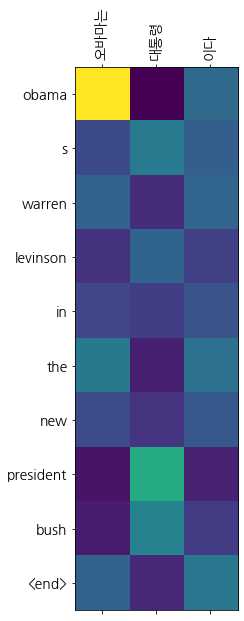

In [35]:
translate('오바마는 대통령 이다',encoder,decoder)

Input: 이것보다 뛰어날 수 있느냐 ?
Predicted translation: you can you ? <end> 


/tmp/ipykernel_147/2860932276.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_147/2860932276.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


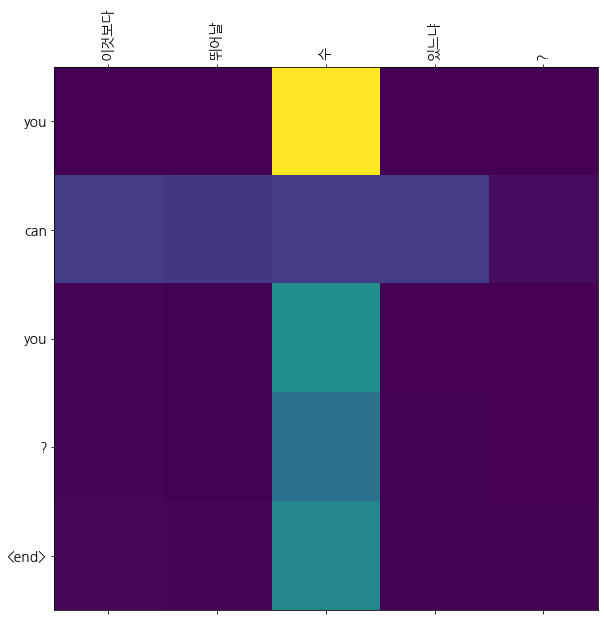

In [38]:
translate('이것보다 뛰어날 수 있느냐?',encoder,decoder)

Input: 북한의 핵 프로그램
Predicted translation: north korea s nuclear program <end> 


/tmp/ipykernel_147/2860932276.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_147/2860932276.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


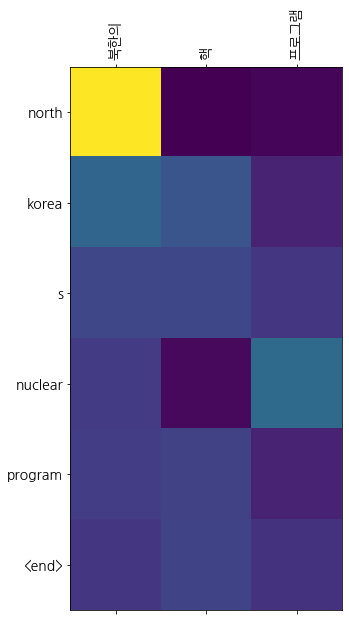

In [42]:
translate('북한의 핵 프로그램',encoder,decoder)

<비고>

* seq2seq 방법으로 한글을 영어로 번역하는 과정은 매우 복잡했습니다.  
* 애초에 데이터의 신뢰도가 낮아 어텐션으로 어느 정도까지 성능이 향상되었는지 확인하기 어려웠습니다.  
* 과제를 하는 과정에서 본인이 한 실수나 잘못된 점 :  
  1) 압축 파일을 잘못 풀었습니다. (tar -zxvf 파일명 으로 해야하나 unzip -d 파일명으로 해서 엉뚱하게    
  각각 하나의 파일로 압축이 풀렸습니다.)  
  2) 때론 복붙이 필요할 때도 있습니다. 그런데 필사하는 과정에서 오타가 나서 결과가 이상하게 나온  
  것을 의심했습니다.  
  3) 아직 언어를 토큰화 하는 과정에 익숙치 않아 처음부터 만만치 않았습니다.    
* 번역 결과를 맵으로 보면 영어는 0과 1 사이의 값으로 정규화되어 있는 반면    
  한국어는 정수값으로 되어 있었습니다. 그래서 처음에는 항상 번역 결과가 단어 하나(The)로 나왔습니다.    
  이런 점은 코드의 초반부에 영어 토크나이저에 word_index 매소드를 써서 해결하였습니다.  
* 위와 같은 수정을 거쳐 불완전 하지만 번역할 한국어의 단어가 어느정도 포함된  
  결과를 얻었습니다.  
* 시간이 허락된다면 루옹(Luong) 어텐션도 시도해보고 싶습니다.  